# Bi-Persistence Clustering on 3D Horse-shaped Mesh Reconstruction Data

This notebook demonstrates the BPSCAN clustering algorithm on a 3D horse-shaped
mesh reconstruction data set. The data was obtained from [a STAD
repository](https://github.com/vda-lab/pySTAD). The meshes were originally
created or adapted for a paper by [Robert W. Sumner and Jovan Popovic
(2004)](https://dl.acm.org/doi/10.1145/1015706.1015736#d17686678e1). They can be
downloaded and are described in more detail on [their
website](https://people.csail.mit.edu/sumner/research/deftransfer/data.html).

In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from umap import UMAP
from biperscan import BPSCAN

from lib.plotting import *

palette = configure_matplotlib()

Uniformly distributed noise points are added to make the clustering task more
difficult.

In [2]:
def noise_from(values, num_samples):
    min, max = values.min(), values.max()
    range = max - min
    offset = 0.1 * range
    return np.random.uniform(min - offset, max + offset, num_samples)


horse = pd.read_csv("data/horse/horse.csv").sample(frac=0.2)
num_noise_samples = horse.shape[0] // 10
df = pd.concat(
    (
        horse[["x", "y", "z"]],
        pd.DataFrame(
            dict(
                x=noise_from(horse.x, num_noise_samples),
                y=noise_from(horse.y, num_noise_samples),
                z=noise_from(horse.z, num_noise_samples),
            )
        ),
    )
)

The BPSCAN algorithm requires a bit of tuning to extract the branches. In
particular, performance appears better when `min_samples` is smaller than
`min_cluster_size`. `distance_fraction` is used to filter out the noise points.
Values up to $0.1$ appear to work quite well in general.

In [18]:
c = BPSCAN(min_samples=15, min_cluster_size=100, distance_fraction=0.05).fit(df)

Visualizing a side-view of the dataset makes it difficult to see whether the
legs are correctly clustered. So, we also show a 2D UMAP projection that
separates the legs and tail.

In [19]:
p = UMAP(n_neighbors=50, repulsion_strength=0.1).fit(df.values)

c:\Users\jelme\micromamba\envs\work\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


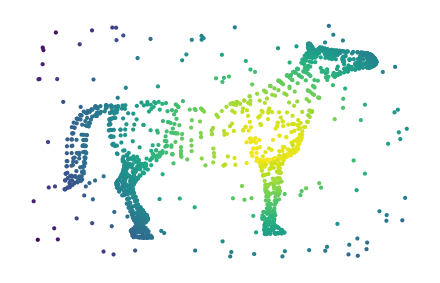

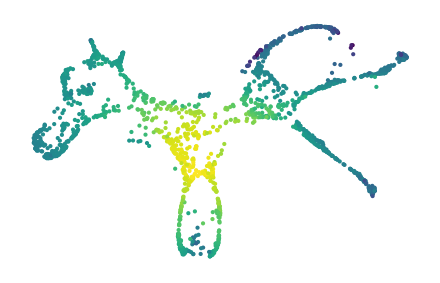

In [20]:
sized_fig(0.5)
plt.scatter(df.z, df.y, s=1, c=c.lens_values_, cmap="viridis")
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")

sized_fig(0.5)
plt.scatter(*p.embedding_.T, s=1, c=c.lens_values_, cmap="viridis")
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.show()

26 merges are detected corresponding to the horse's legs, head, and tail.

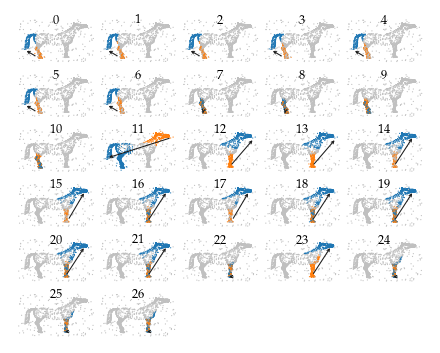

In [21]:
sized_fig(0.5, aspect=0.8)
merges = c.merges_
merges.plot_merges(df.z.to_numpy(), df.y.to_numpy(), s=0.33, title_y=0.6, arrowsize=3, linewidth=0.5)
plt.subplots_adjust(0, 0, 1, 0.975, wspace=0)
plt.axis("off")
plt.show()

Combining the (near) duplicate merges results in 8 simplified merges that exist
at several stages in the bi-filtration:

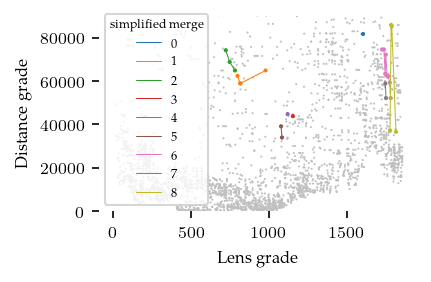

In [22]:
sized_fig(0.5)
c.simplified_merges_.plot_persistence_areas()
plt.show()

The simplified merges still describe the legs, tail, head, and (depending on the
parameters setting) even ears and nose are detected as branches.

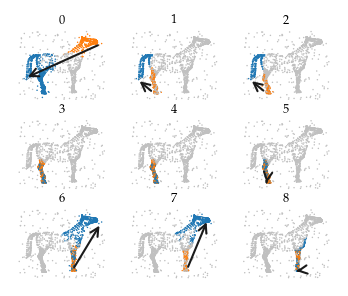

In [23]:
sized_fig(0.5, 0.8)
c.simplified_merges_.plot_merges(df.z.to_numpy(), df.y.to_numpy(), s=0.5)

The cluster labels extracted from these merges segment the data set fairly well:

In [24]:
scatter_kwargs = dict(s=1, alpha=0.5, linewidths=0, edgecolor="none")
colors = plt.cm.tab20.colors
color_kwargs = dict(
    cmap=ListedColormap(["silver"] + [colors[i] for i in range(20)]), vmin=-1, vmax=19
)

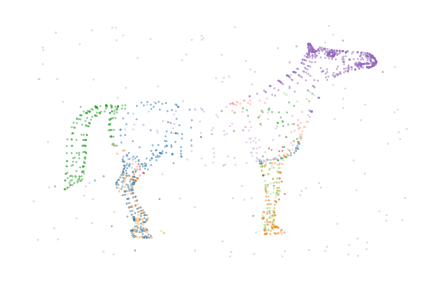

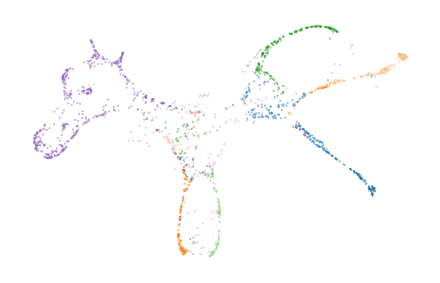

In [25]:
sized_fig(0.5)
plt.scatter(df.z, df.y, c=c.labels_ % 10, **color_kwargs, **scatter_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")

sized_fig(0.5)
plt.scatter(*p.embedding_.T, c=c.labels_ % 10, **color_kwargs, **scatter_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.show()